# Eye traces in pipeline

In [ ]:
%pylab inline
pylab.rcParams['figure.figsize'] = (6, 6)

In [1]:
%matplotlib inline
import datajoint as dj
from pipeline import vis, preprocess
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DataJoint 0.3.7 (July 31, 2016)
Loading local settings from /home/fabee/.datajoint_config.json
Connecting fabee@at-database.ad.bcm.edu:3306
Loading local settings from /home/fabee/.pipeline_config.json


Eye tracking traces are in `EyeTracking` and in its part table `EyeTracking.Frame`. `EyeTracking` is a grouping table that refers to one scan and one eye video, whereas  `EyeTracking.Frame` contains the single frames. The table `BehaviorSync` is used to synchronize the behavior measurements (Treadmill, Eyetracking) to the scan frames. 

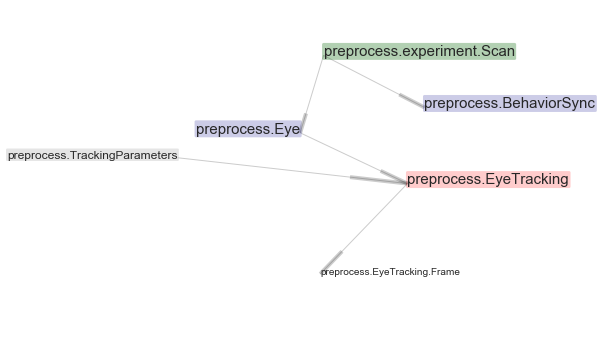

In [2]:
(dj.ERD.from_sequence([preprocess.EyeTracking,preprocess.BehaviorSync]) - 1 + \
     dj.ERD(preprocess.EyeTracking).add_parts()).draw()

In this notebook, we'll fetch the pupil radius and position, and plot it along with a calcium trace, all on the behavior clock. The relative times of the eye, treadmill, and trace are precise, but the clock itself starts at some arbitrary offset.

In [3]:
# choose an arbitrary scan
key = dict(animal_id=8804, session=1, scan_idx=3)

## Eye


In [4]:
# Fetch the pupil radius trace and the centers
r, center = (preprocess.EyeTracking.Frame() & key).fetch['major_r', 'center']

In [5]:
# undetected frames are nans in the radius trace
detectedFrames = ~np.isnan(r)

In [6]:
# convert positions to a 2d numpy array
xy = np.full((len(r),2),np.nan)
xy[detectedFrames, :] = np.vstack(center[detectedFrames])

In [7]:
# get pupil tracking times on the behavior clock
et = (preprocess.Eye() & key).fetch1['eye_time']

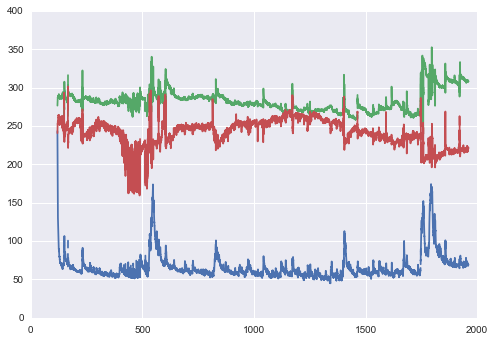

In [8]:
# plot xy position and radius
plt.plot(et,r)
plt.plot(et,xy)

## Calcium Traces

In [10]:
# choose an arbitrary calcium trace
trace_key = dict(key, extract_method=2, trace_id=256)

# ...and fetch the trace
tr = (preprocess.ComputeTraces.Trace() & trace_key).fetch1['trace']

Join the trace and segmentation tables to get more info about this trace and the mask used to generate it

In [11]:
tr_info = preprocess.ComputeTraces.Trace() * preprocess.ExtractRaw.GalvoROI() & trace_key
tr_info

animal_id,session,scan_idx,extract_method,trace_id,slice,channel,trace,mask_pixels,mask_weights
8804,1,3,2,256,3,1,=BLOB=,=BLOB=,=BLOB=


...and fetch the trace and slice number for the single trace  from the joined tables using fetch1

In [14]:
tr, slice_no = (preprocess.ComputeTraces.Trace() * preprocess.ExtractRaw.GalvoROI() 
                & trace_key).fetch1['trace','slice']


Fetch the imaging frame times on the behavior clock and the number of slices per scan

In [13]:
ft, nslices = (preprocess.BehaviorSync() * preprocess.Prepare.Galvo() 
               & key).fetch1['frame_times','nslices']


In a single scan with 3 slices, imaging frames are collected from slice 1, 2, 3, 1, 2, 3...

So there are `nslices * length(tr)` frame times

In [15]:
assert nslices*len(tr)==len(ft),\
            'You should never see this message unless the scan was aborted'


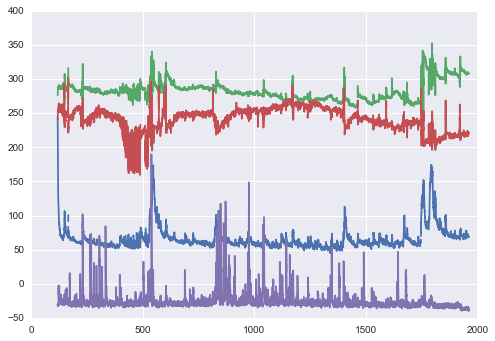

In [16]:
# get the frame times for this slice
ft_slice = ft[slice_no-1::nslices] # slices are numbered 1 based


# Plot the trace to the pupil plot with some scaling
plt.plot(et,r)
plt.plot(et,xy)
plt.plot(ft_slice,tr/tr.min()*20-60)


## Visual stimulus

In [17]:
# fetch the frame times on the visual stimulus clock
vt = (preprocess.Sync() & key).fetch1['frame_times'].squeeze()
vt_slice = vt[slice_no-1::nslices]

# get the trials and for this scan and their flip times
flip_times = (vis.Trial() * preprocess.Sync() & key 
          & 'trial_idx > first_trial and trial_idx < last_trial').fetch['flip_times']


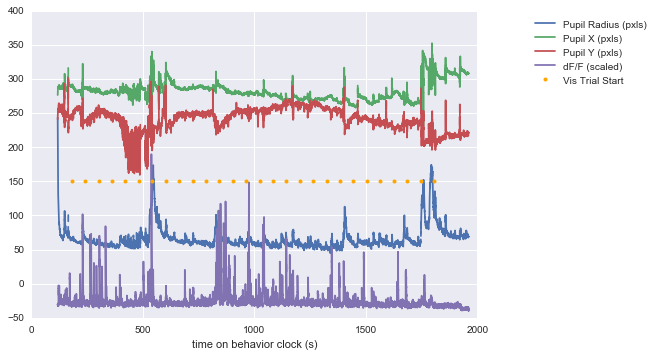

In [18]:
plt.plot(et,r)
plt.plot(et,xy)
plt.plot(ft_slice,tr/tr.min()*20-60)

for flip_time in flip_times:
    # Get the imaging frame where the vis stim trial started
    
    start_idx = np.where(vt_slice > flip_time[0,0])[0][0]
    
    # Use that frame to index into the times on the behavior clock
    plt.plot(ft_slice[start_idx],150,'ok', mfc='orange', ms=4)


plt.legend(['Pupil Radius (pxls)', 'Pupil X (pxls)','Pupil Y (pxls)',
            'dF/F (scaled)', 'Vis Trial Start'], bbox_to_anchor=(1.4,1),
          bbox_transform=plt.gca().transAxes)
plt.xlabel('time on behavior clock (s)')

